# Star Finding & Photometry with photutils


The full instructions are here:
https://photutils.readthedocs.io/en/stable/getting_started.html

If you haven't installed photutils, `%pip install photutils`

In [1]:
%pip install photutils

Note: you may need to restart the kernel to use updated packages.


In [1]:
cd data_mar8_2021

/Users/zeinakellybenton/obs_tech/data_mar8_2021


In [2]:
#pip install photutils

In [3]:
from astropy.io import fits
import photutils

In [4]:
from photutils.detection import DAOStarFinder

In [5]:
#%matplotlib 
import pylab as pl
import numpy as np
pl.style.use('dark_background')

In [6]:
fitsfile = fits.open('pleiades_30s_C_other_001_darksub_flattened.fits')
efitsfile = fits.open('pleiades_30s_C_other_001_darksub_flattened_uncertainty.fits')

First step: you need to know the PSF size!

Use what you learned in the 'measuring star properties' notebook

In [7]:
# load the image
image = fitsfile[0].data

In [8]:
# it is not background-subtracted yet, so we'll estimate and remove the background:
background = np.median(image)
background

1034.4351460591995

In [9]:
image_bgsub = image - background

In [10]:
cx,cy = 205,101
star_cutout = image_bgsub[cy-10:cy+10, cx-10:cx+10]

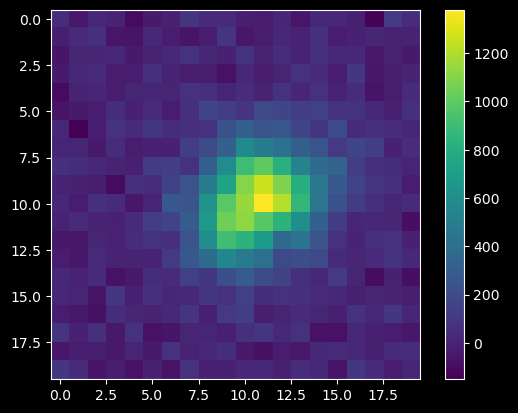

In [11]:
pl.imshow(star_cutout); _=pl.colorbar()

In [12]:
yc, xc = np.indices(star_cutout.shape)
mom1_x = (xc * star_cutout).sum() / star_cutout.sum()
mom1_y = (yc * star_cutout).sum() / star_cutout.sum()
mom2_x = ((xc - mom1_x)**2 * star_cutout).sum() / star_cutout.sum()
mom2_y = ((yc - mom1_y)**2 * star_cutout).sum() / star_cutout.sum()
sigma_x, sigma_y = mom2_x**0.5, mom2_y**0.5
sigma_to_fwhm = np.sqrt(8*np.log(2))
fwhm_x, fwhm_y = sigma_x*sigma_to_fwhm, sigma_y*sigma_to_fwhm
avg_fwhm = (fwhm_x*fwhm_y)**0.5
print(f"FWHM average, in pixels: {avg_fwhm}")

FWHM average, in pixels: 5.205165654895971


In [13]:
# estimate the background noise
from astropy.stats import mad_std
background_stddev = mad_std(image_bgsub)
background_stddev

47.300474347343446

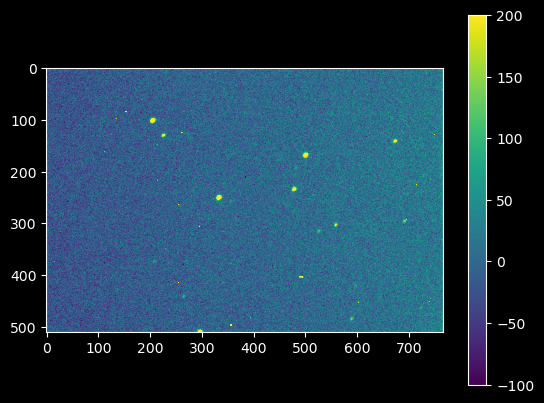

In [14]:
pl.imshow(image_bgsub, vmax=200, vmin=-100); _=pl.colorbar()

In [15]:
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=3.*background_stddev)  
sources = daofind(image_bgsub)

In [16]:
sources.show_in_notebook()

         interactive tables it is recommended to use dedicated tools like:
         - https://github.com/bloomberg/ipydatagrid
         - https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html#datatable
         - https://dash.plotly.com/datatable [warnings]


In [17]:
from photutils.aperture import aperture_photometry, CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=avg_fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
phot_table

<QTable length=194>
  id   xcenter   ycenter  aperture_sum
         pix       pix                
int64  float64   float64    float64   
----- --------- --------- ------------
    1 6.5129966 4.5940981   -983.85837
    2 232.15659 5.6582273    880.94612
    3 78.275192 6.2616953   -1069.4228
    4 374.13626 9.6993911    246.59734
    5 143.98884 15.881792   -800.77301
    6 667.07542 22.698403    1447.5296
    7 732.18566 23.043105    1460.3352
    8 435.92744 28.451139    747.34463
    9 100.04213 31.002688   -1349.0486
  ...       ...       ...          ...
  186 439.13563 482.07613    121.29259
  187 589.95768 483.60508    5616.3763
  188 765.06146 484.44491    2189.9559
  189 570.97713 495.37858    603.51956
  190 357.08382  496.3576    16355.912
  191 469.20181 498.28359    175.76886
  192 116.66325 500.76872   -2517.3484
  193 234.97898 499.58704   -1322.4505
  194 296.92958 508.01231    17230.402

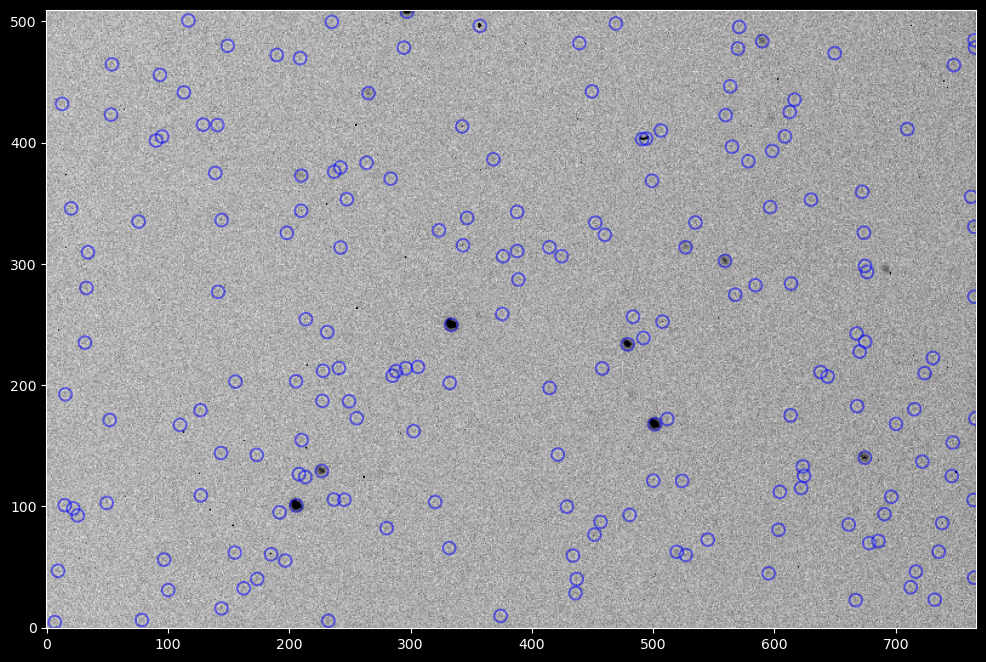

In [18]:
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-200)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)

That was _way_ too aggressive!  Let's try a higher threshold:

In [19]:
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=6.*background_stddev)  
sources = daofind(image_bgsub)

In [20]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=avg_fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
phot_table

<QTable length=11>
  id   xcenter   ycenter  aperture_sum
         pix       pix                
int64  float64   float64    float64   
----- --------- --------- ------------
    1 205.62452 100.79501     38170.46
    2 226.71968 129.19057    10081.012
    3 674.56794 140.15838    11614.489
    4 501.27849 167.84401    32891.715
    5 478.97722 233.65154    18359.055
    6 333.51779 249.79111    38676.986
    7 559.21894 302.53448    8130.3857
    8 490.88919 402.88006    7489.0726
    9 494.02229 403.28589    7607.5328
   10 357.08382  496.3576    16355.912
   11 296.92958 508.01231    17230.402

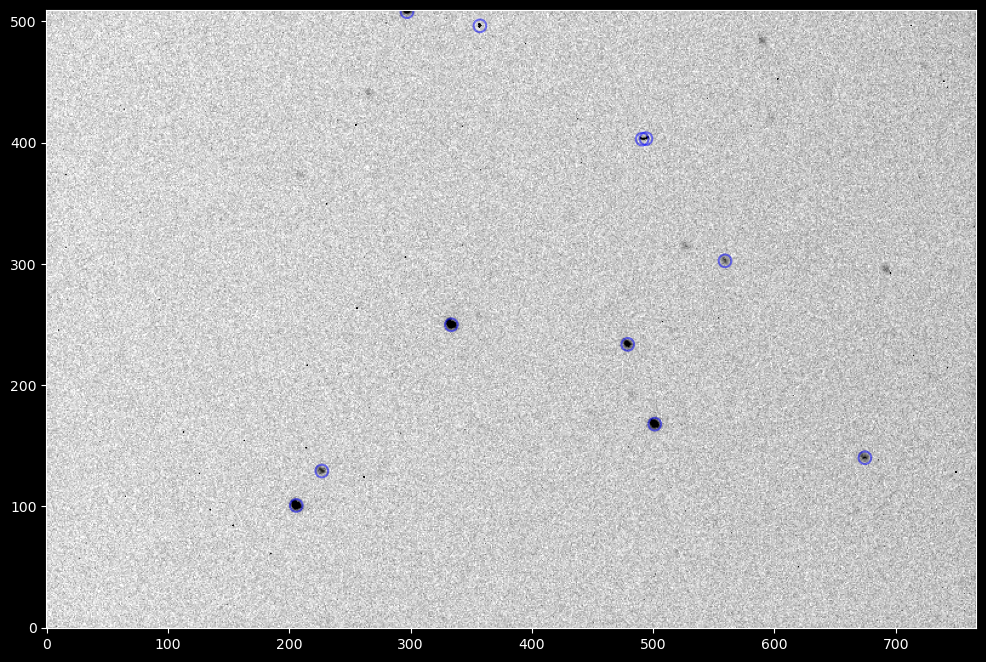

In [21]:
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-100)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)

Not aggressive enough!  Let's keep tuning...

<QTable length=23>
  id   xcenter   ycenter  aperture_sum
         pix       pix                
int64  float64   float64    float64   
----- --------- --------- ------------
    1 184.89571 60.513785   -545.16299
    2 154.93314 61.932481   -1215.9783
    3  519.4154 62.547918    1288.2592
    4 280.17026 82.112555    225.33916
    5 205.62452 100.79501     38170.46
    6 226.71968 129.19057    10081.012
    7 674.56794 140.15838    11614.489
    8 501.27849 167.84401    32891.715
    9 637.99384 210.83123    1108.2062
  ...       ...       ...          ...
   15 483.35411 256.43884     110.4235
   16 559.21894 302.53448    8130.3857
   17 490.88919 402.88006    7489.0726
   18 494.02229 403.28589    7607.5328
   19 342.47168 413.39841    867.99808
   20 265.24673 440.81657    3010.8035
   21 589.95768 483.60508    5616.3763
   22 357.08382  496.3576    16355.912
   23 296.92958 508.01231    17230.402

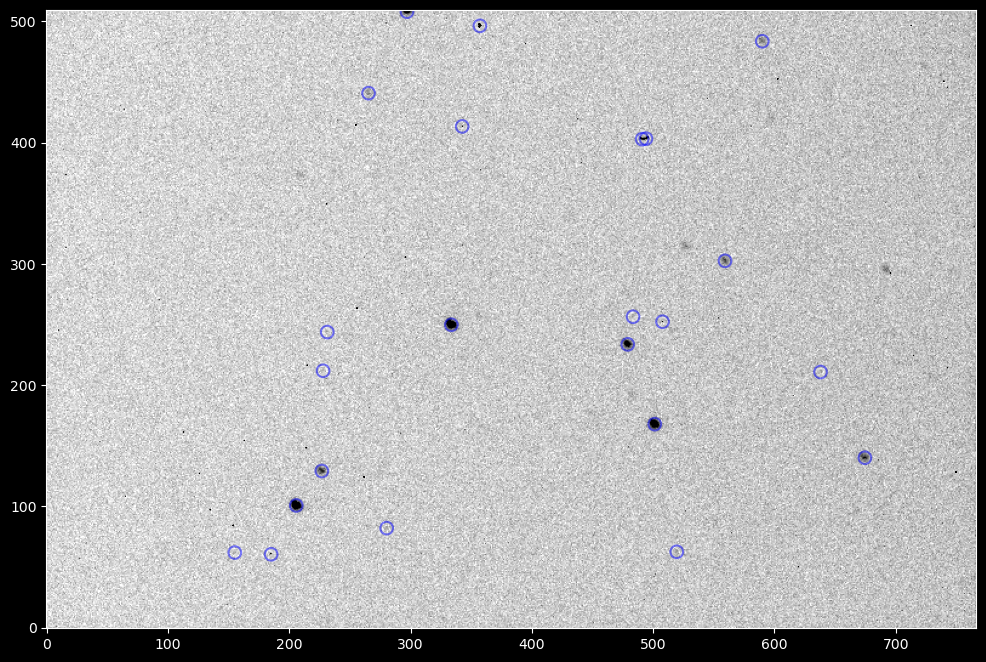

In [22]:
daofind = DAOStarFinder(fwhm=avg_fwhm, threshold=4.*background_stddev)  
sources = daofind(image_bgsub)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=avg_fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-100)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)
phot_table

This still picks up some false stars and misses some real ones.

It may be that we under-estimated the FWHM, and some stars are more smeared out than others, so we can try adjusting the FWHM:

<QTable length=23>
  id   xcenter   ycenter  aperture_sum
         pix       pix                
int64  float64   float64    float64   
----- --------- --------- ------------
    1 764.56192 41.295608    3798.7436
    2 668.04576 96.217106    3397.6375
    3 205.64139 100.82853    41693.348
    4 226.52018 129.31529    10618.646
    5 674.48726 140.25214    13642.942
    6 214.21249 147.90351   -265.59784
    7 113.16558  161.3594   -2045.7403
    8 501.25289 167.85194    37094.892
    9 666.95702 167.28288    2817.9358
  ...       ...       ...          ...
   15 526.85258 314.28705    5657.8669
   16  630.1943 353.06809    1639.1363
   17 15.786587 373.29283   -3471.8334
   18 644.59155 391.85486    2450.1558
   19  491.4271 402.89888    7812.0405
   20 265.46484  440.8506    2766.8599
   21  590.1301 483.67814     6728.482
   22 357.09549  496.3144    16250.005
   23 296.95602 507.91524    18665.675

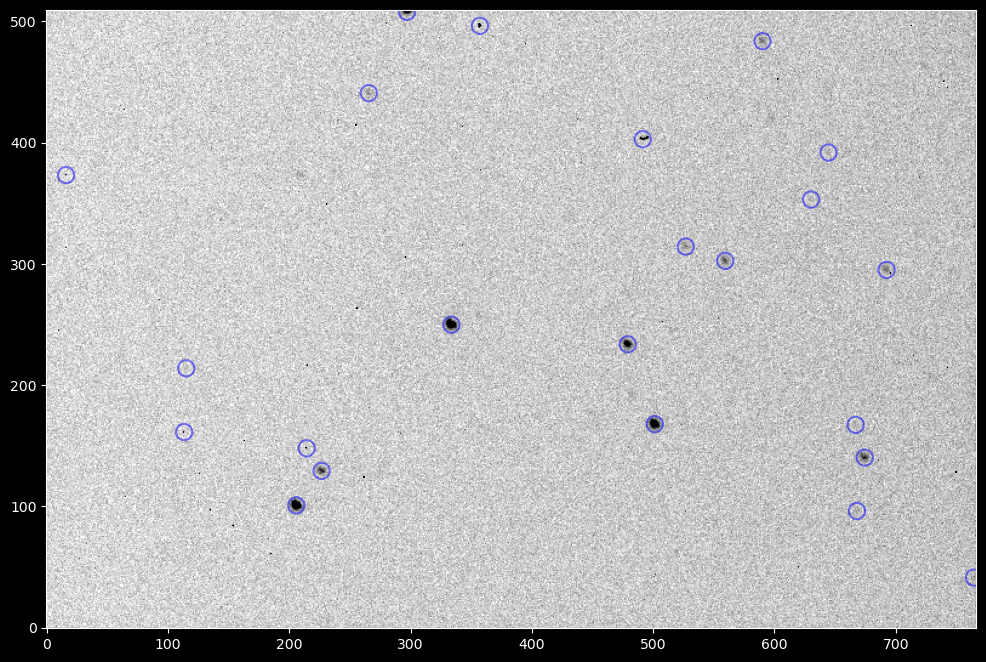

In [23]:
fwhm = 6.7
daofind = DAOStarFinder(fwhm=fwhm, threshold=4.*background_stddev)  
sources = daofind(image_bgsub)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=fwhm)  
phot_table = aperture_photometry(image_bgsub, apertures)  
for col in phot_table.colnames:  
    phot_table[col].info.format = '%.8g'  # for consistent table output
pl.figure(figsize=(12,12))
pl.imshow(image_bgsub, cmap='gray_r', origin='lower', vmax=400, vmin=-100)
_=apertures.plot(color='blue', lw=1.5, alpha=0.5)
phot_table

Now it looks like we got everything, and _most_ of the sources are real.  There are still some hot pixels we'd rather exclude - this is why it's important to do good alignment and median combination first!

# Error Estimation

https://photutils.readthedocs.io/en/stable/aperture.html#error-estimation

In [24]:
e_phot_table = aperture_photometry(efitsfile[0].data**2, apertures)
phot_table.add_column(e_phot_table['aperture_sum']**0.5, name='aperture_sum_uncertainty')
phot_table

<QTable length=23>
  id   xcenter   ycenter  aperture_sum aperture_sum_uncertainty
         pix       pix                                         
int64  float64   float64    float64            float64         
----- --------- --------- ------------ ------------------------
    1 764.56192 41.295608    3798.7436       407.89854016297676
    2 668.04576 96.217106    3397.6375         494.755636014125
    3 205.64139 100.82853    41693.348        530.8986299396488
    4 226.52018 129.31529    10618.646       500.08082802706383
    5 674.48726 140.25214    13642.942       506.80486760280803
    6 214.21249 147.90351   -265.59784        490.6564401786945
    7 113.16558  161.3594   -2045.7403        487.7816345998436
    8 501.25289 167.85194    37094.892        529.0088017511401
    9 666.95702 167.28288    2817.9358       494.78424240649537
  ...       ...       ...          ...                      ...
   15 526.85258 314.28705    5657.8669       496.70453338895084
   16  630.1943 353.06809    1639.1363        495.6301651888331
   17 15.786587 373.29283   -3471.8334       486.26751880857313
   18 644.59155 391.85486    2450.1558        496.0131951630611
   19  491.4271 402.89888    7812.0405        498.8818816541834
   20 265.46484  440.8506    2766.8599       492.45610167006953
   21  590.1301 483.67814     6728.482        500.8629577975555
   22 357.09549  496.3144    16250.005         4248.27362041987
   23 296.95602 507.91524    18665.675       414.05560759186613

In [25]:
phot_table = aperture_photometry(image_bgsub, apertures, error=efitsfile[0].data)
phot_table

<QTable length=23>
  id       xcenter       ...     aperture_sum     aperture_sum_err 
             pix         ...                                       
int64      float64       ...       float64            float64      
----- ------------------ ... ------------------- ------------------
    1    764.56192203779 ...   3798.743577970813 407.89854016297676
    2  668.0457553471205 ...   3397.637458401452   494.755636014125
    3   205.641394677659 ...   41693.34813722851  530.8986299396488
    4  226.5201786015808 ...  10618.646448153195 500.08082802706383
    5  674.4872615281635 ...   13642.94246242104 506.80486760280803
    6 214.21248586732105 ...  -265.5978369702369  490.6564401786945
    7  113.1655786554732 ... -2045.7403478778424  487.7816345998436
    8 501.25289231902514 ...   37094.89248053511  529.0088017511401
    9  666.9570168480788 ...  2817.9358177993336 494.78424240649537
  ...                ... ...                 ...                ...
   15  526.8525816473363 ...   5657.866869296927 496.70453338895084
   16  630.1943007627453 ...   1639.136270323553  495.6301651888331
   17 15.786587040584454 ...  -3471.833403830473 486.26751880857313
   18  644.5915467456339 ...  2450.1557906110716  496.0131951630611
   19  491.4271018966055 ...   7812.040523608284  498.8818816541834
   20 265.46484485848515 ...  2766.8598646794785 492.45610167006953
   21  590.1301024060762 ...   6728.481961333527  500.8629577975555
   22  357.0954930263252 ...  16250.005147544794   4248.27362041987
   23 296.95601582893397 ...  18665.674623398267 414.05560759186613

__Question__: Explain how this would be useful for Lab 7 (either cluster CMDs or time-domain data analysis)

__Answer:__ 

Aperature photometry will be useful for lab 7's cluster CMDs as it helps distinguish the light from each star by defining the region around the star for measurement from a background. The aperture sum, or the total light measured within a specific region aorund a star, would be important here to to determine a star's apparent magnitude and color index in a CMD which will impact accuracy and the uncertainty property assists in measurement accuracy as well. 